# Computación Bio-inspirada. Bloque II: Machine Learning. 
# 15 Multi-objective correlation-based feature selection con algoritmos evolutivos multi-objetivo (pymoo) 

Santiago Méndez García (s.mendezgarcia@um.es), Domingo Méndez García (domingo.mendezg@um.es)

Computación Bio-inspirada. Máster en Inteligencia Artificial. Universidad de Murcia. Curso 2024/2025.

## 1. Objetivos y metodología

Diseñar un AE como estrategia de búsqueda del método correlation-based feature
selection (Tema 5, pág. 11) pero usando el enfoque multi-objetivo propuesto en el Tema
5, pág. 13. Implementar el AE con representación binaria, selección
por ranking exponencial (c = 0.3), muestreo estocástico con reemplazo, sustitución
generacional completa, cruce uniforme (𝑝𝑝𝑐𝑐 = 0.6), mutación bit-flip (𝑝𝑝𝑚𝑚 = 0.1) y
100000 evaluaciones de la función objetivo. Ejecutar el AE 10 veces con diferente
semilla para el conjunto de datos ALL-AML_train 5 . Visualizar gráficamente la
evolución del algoritmo (10 runs sobre el mismo gráfico). Reportar la siguiente tabla
de resultados:

| Seed | HV | ACC ALL-AML_train RF | ACC ALL-AML_train SVM | ACC ALL-AML_train MLP | ACC ALL-AML_test RF | ACC ALL-AML_test SVM | ACC ALL-AML_test MLP |
|------|---------|-----------------------|------------------------|------------------------|----------------------|-----------------------|-----------------------|
| 1    |         |                       |                        |                        |                      |                       |                       |
| 2    |         |                       |                        |                        |                      |                       |                       |
| ...  |         |                       |                        |                        |                      |                       |                       |
| 10   |         |                       |                        |                        |                      |                       |                       |
| Mejor   |     |                       |                        |                        |                      |                       |                       |
| Peor    |     |                       |                        |                        |                      |                       |                       |
| Promedio |   |                       |                        |                        |                      |                       |                       |
| Desv. Tip. |  |                       |                        |                        |                      |                       |                       |


Para RF, SVM y MLP usar sklearn.ensemble.RandomForestClassifier,
sklearn.svm.SVC y sklearn.neural_network, respectivamente con los hiperparámetros por defecto. Por otro lado, reportar la siguiente tabla:

| Todos los atributos |                        |                        |                        |                       |                       |                       |
|---------------------|------------------------|------------------------|------------------------|-----------------------|-----------------------|-----------------------|
| ACC ALL-AML_train RF | ACC ALL-AML_train SVM | ACC ALL-AML_train MLP | ACC ALL-AML_test RF | ACC ALL-AML_test SVM | ACC ALL-AML_test MLP |
|                      |                        |                        |                       |                       |                       |

En la primera tabla reportada, cambiar fitness por HV (hipervolumen) y el
resto de los resultados se corresponderán con los de la mejor solución no-dominada
identificada por el MOEA. Consideramos la mejor solución no dominada como, para cada modelo de ML, la solución no dominada de la población obtenida por el MOEA que obtenga mejor métrica accuracy en validación.

### Requerimientos

A continuación se importan las librerías de _Python_ necesarias, se establece la semilla de _Numpy_ para la reproducibilidad y se definen la ruta del directorio donde se guardarán los resultados y algunas variables que se pueden utilizar para hacer pruebas de menor tamaño o utilizar los resultados ya guardados.

In [1]:
# === Bibliotecas estándar de Python ===
import os # crear y leer archivos
import sys
import time # tiempos de ejecución
import copy # copia profunda de objetos (callback pymoo)
import random
import pickle # guardar y cargar objetos
import warnings
import pkg_resources

# === Utilidades para notebooks ===
from IPython.display import display, HTML

# === Bibliotecas científicas ===
import numpy as np                           # Vectores y matrices
import pandas as pd                          # Dataframes
import matplotlib.pyplot as plt              # Gráficos
from scipy.io import arff                    # Lectura de archivos .arff (Weka)
from scipy.stats import pointbiserialr       # Correlación punto-biserial

# === Scikit-learn: ML y procesamiento ===
from sklearn.preprocessing import LabelEncoder            # Codificación de variables categóricas
from sklearn.impute import SimpleImputer                  # Imputación de valores faltantes
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold)      # División y validación cruzada
from sklearn.exceptions import ConvergenceWarning          # Manejador de warnings

# == modelos para la práctica ==

from sklearn.ensemble import RandomForestClassifier        # Clasificador de Bosques Aleatorios
from sklearn.svm import SVC                                # Clasificador de Vectores de Soporte
from sklearn.neural_network import MLPClassifier           # Perceptrón multicapa

# === Pymoo: Optimización multiobjetivo evolutiva ===
import pymoo                                               # Framework de optimización multiobjetivo

# Algoritmos evolutivos
from pymoo.algorithms.moo.nsga2 import NSGA2               # Algoritmo NSGA-II

# Problemas y núcleo

from pymoo.core.problem import ElementwiseProblem          # Definición del problema multiobjetivo

# Terminación y optimización
from pymoo.optimize import minimize                        # Función principal de optimización
from pymoo.termination import get_termination              # Criterios de parada

# Visualización de resultados
from pymoo.util.plotting import plot
from pymoo.visualization.scatter import Scatter            # Dispersión de soluciones
from pymoo.visualization.pcp import PCP                    # Parallel Coordinate Plot

# Métricas de calidad
from pymoo.indicators.gd import GD                         # Generational Distance
from pymoo.indicators.gd_plus import GDPlus
from pymoo.indicators.igd import IGD                       # Inverted GD
from pymoo.indicators.igd_plus import IGDPlus
from pymoo.indicators.hv import HV                         # Hypervolume

# Operadores evolutivos
from pymoo.operators.crossover.ux import UniformCrossover  # Cruce uniforme (binario)
from pymoo.operators.mutation.bitflip import BitflipMutation  # Mutación bitflip
from pymoo.operators.sampling.rnd import (Sampling,
                                          BinaryRandomSampling)  # Muestreo aleatorio binario

# Utilidades adicionales de pymoo
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting  # Ordenación por no dominación
from pymoo.core.callback import Callback                   # Callbacks para guardar resultados por generación
from pymoo.core.selection import Selection                 # Clase base para selección

# === Warnings (desactivación de advertencias) ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter("ignore", category=UserWarning)


profiling = True # Poner a True para hacer profiling

DATASET_NAME = '../DATASETS/ALL-AML' # Atributos numéricos y categóricos
DATASET_TRAIN_PATH = DATASET_NAME + '_train.arff' # Ruta del archivo de entrenamiento
DATASET_TEST_PATH = DATASET_NAME + '_test.arff' # Ruta del archivo de prueba

RESULTS_DIR = 'cbio_p15_results' if not profiling else 'cbio_p15_results_profiling' # Directorio de resultados

DONE = False # Poner a True para ejecutar los algoritmos y entrenamientos
LOAD = DONE # Cargar resultados de pruebas anteriores

SEED = 2025
np.random.seed(SEED)   # Establecer semilla
random.seed(SEED) # Establecer semilla

/tmp/ipykernel_1334122/3544570786.py:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
# Reportar versiones de las librerías

# Obtenemos la versión de Python
version_python = sys.version

# Crear contenido HTML para mostrar en el notebook
html_content = f"""
<table>
    <tr><th>Python Version</th></tr>
    <tr><td>{version_python}</td></tr>
</table>
"""

# Mostrar la versión de Python en el notebook
display(HTML(html_content))

# Obtenemos la versión de las librerías

# Define la lista de librerías que deseas verificar
librerias_interes = [
"ipython",
"landscapes",
"matplotlib",
"numpy",
"pandas",
"scipy",
"sklearn",
"tqdm",
"pymoo",
"pyswarms",
]
# Crear una lista con las versiones de las librerías de interés
versiones = []
for lib in librerias_interes:
    try:
        version = pkg_resources.get_distribution(lib).version
        versiones.append((lib, version))
    except pkg_resources.DistributionNotFound:
        versiones.append((lib, "No instalada"))

# Generar una tabla en HTML para mostrar en el notebook
html_content = "<table>"
html_content += "<tr><th>Library</th><th>Version</th></tr>"
for package_name, version in versiones:
    html_content += f"<tr><td>{package_name}</td><td>{version}</td></tr>"
html_content += "</table>"

# Mostrar la tabla en el notebook
display(HTML(html_content))

Python Version
"3.8.10 (default, Jun 4 2021, 15:09:15) [GCC 7.5.0]"


Library,Version
ipython,8.4.0
landscapes,0.0.11
matplotlib,3.5.2
numpy,1.23.1
pandas,1.4.3
scipy,1.9.0
sklearn,0.0
tqdm,4.64.0
pymoo,0.6.0
pyswarms,1.3.0


### Cargar Dataset

In [3]:
def LoadData(file_path):

    data, meta = arff.loadarff(file_path)

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Separar atributos numéricos y categóricos
    numeric_attributes = df.iloc[:, :-1] .select_dtypes(include=['int', 'float']).columns
    categorical_attributes =  df.iloc[:, :-1].select_dtypes(include=['object']).columns
    
    # Imputación para atributos numéricos
    if numeric_attributes.size>0:
        df[numeric_attributes] = SimpleImputer(strategy='mean').fit_transform(df[numeric_attributes])
        
    # Imputación para atributos categóricos
    # Aplicar hot encoding
    if categorical_attributes.size>0:
        df[categorical_attributes] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_attributes])
        X = pd.get_dummies(data=df.iloc[:, :-1], columns=categorical_attributes)    
        X = X.astype(float)
    else:
        X = df.iloc[:, :-1]    
    
    # Salida: y
    y = [label.decode('utf-8') for label in df.iloc[:, -1]]
    class_values = meta[meta.names()[-1]][1]  # Obtiene los valores posibles de la clase 
    le = LabelEncoder() # para codificar la clase binaria
    le.fit(class_values)
    y = le.transform(y)
    y = y.astype(np.int32)

    return X,y

In [4]:
def summarize_arff(file_path):
    """
    Summarizes an ARFF dataset by providing the number of rows, features, 
    data types, and basic statistics for numerical features.
    
    Args:
        file_path (str): Path to the ARFF file.
    """
    # Load the ARFF file
    data, meta = arff.loadarff(file_path)
    
    # Convert to a Pandas DataFrame
    df = pd.DataFrame(data)
    
    # Display basic information
    print(f"Dataset Summary for: {file_path}")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")
    print("\nFeature Types:")
    print(df.dtypes)
    
    # Separate numerical and categorical features
    numeric_features = df.select_dtypes(include=['int64', 'float64'])
    categorical_features = df.select_dtypes(include=['object'])
    
    # Count nans in all features
    nan_counts = df.isnull().sum().sum()
    print(f"\nNaN Counts:{nan_counts}")
    
    # Display unique values for categorical features
    if not categorical_features.empty:
        print("\nCategorical Features Unique Values:")
        for col in categorical_features.columns:
            print(f"{col}: {df[col].nunique()} unique values")

In [5]:
summarize_arff(DATASET_TRAIN_PATH)

Dataset Summary for: ../DATASETS/ALL-AML_train.arff
Number of rows: 38
Number of features: 7130

Feature Types:
attribute1       float64
attribute2       float64
attribute3       float64
attribute4       float64
attribute5       float64
                  ...   
attribute7126    float64
attribute7127    float64
attribute7128    float64
attribute7129    float64
myclass           object
Length: 7130, dtype: object

NaN Counts:0

Categorical Features Unique Values:
myclass: 2 unique values


El dataset de train, ALL-AML_train, tiene 38 filas y 7130 columnas, de las cuales 7129 son atributos predictores numéricos y 1 es el target, que es una etiqueta binaria.

In [6]:
X_train,y_train = LoadData(DATASET_TRAIN_PATH)
X_test,y_test = LoadData(DATASET_TEST_PATH)

K = 4 if not profiling else 2
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

Cargamos los datasets de train y test y generamos una partición de crosvalidación estratificada para la validación de los modelos de ML.

In [7]:
print(f"Test dataset shape: {X_test.shape}")

Test dataset shape: (34, 7129)


El dataset de test tiene 34 ejemplos.

In [8]:
n_features = X_train.shape[1]

print(f"Train dataset shape: {X_train.shape}")

Train dataset shape: (38, 7129)


In [9]:
# Number of target classes
n_classes = len(np.unique(y_train))
print(f"Number of classes: {n_classes}")

Number of classes: 2


In [10]:
# Correlations between features and target
correlations = []
for i in range(n_features):
    corr, _ = pointbiserialr(X_train.iloc[:, i], y_train)
    correlations.append((i, abs(corr)))
correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)
print("Top 10 features by correlation with target:")
for i, corr in correlations[:10]:
    print(f"Feature {i}: {corr:.4f}")

Top 10 features by correlation with target:
Feature 3319: 0.8283
Feature 4846: 0.8223
Feature 2019: 0.8112
Feature 1744: 0.7768
Feature 5038: 0.7765
Feature 1833: 0.7707
Feature 460: 0.7578
Feature 4195: 0.7495
Feature 3846: 0.7471
Feature 2287: 0.7435


In [11]:
# Correlation stats
corr_mean = np.mean([abs(corr) for _, corr in correlations])
corr_std = np.std([abs(corr) for _, corr in correlations])
print(f"Mean abs correlation: {corr_mean}")
print(f"Std abs correlation: {corr_std}")

Mean abs correlation: 0.21104677988912493
Std abs correlation: 0.1499615311134631


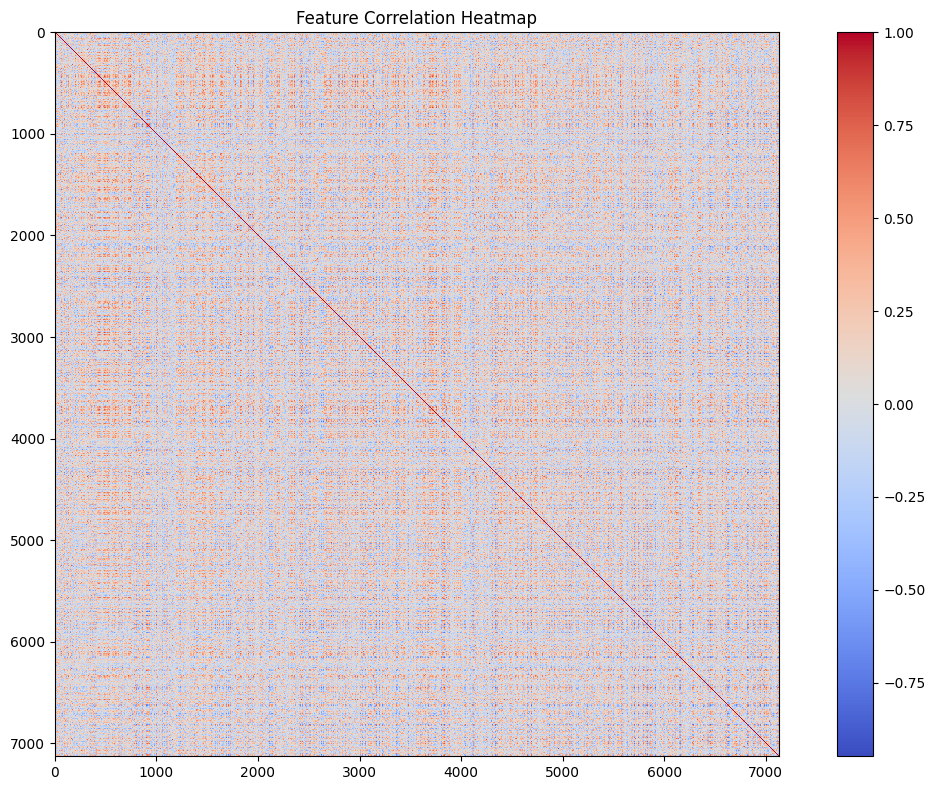

In [12]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
plt.title("Feature Correlation Heatmap")
plt.imshow(X_train.corr(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.tight_layout()
plt.show()

## 2. Problema del Multi-objective correlation-based feature selection 

El problema de la selección de atributos (SA), o *feature selection*, en Machine Learning (ML) se trata de, dado un dataset, seleccionar el subconjunto de atributos mínimo más "relevante" o "útil" para la tarea de predicción. Las principales razonas para aplicar SA son reducir el tiempo de entrenamiento y/o la complejidad del modelo, evitando overfitting y facilitando la interpretabilidad, incluso en ocasiones mejorando la precisión del modelo. Dependiendo del enfoque utilizado, la relevancia o utilidad del subconjunto de atributos puede medirse de distintas formas, dando lugar a distintos tipos de SA. Los problemas de SA se pueden clasificar principalmente en:

-  **Evaluación de atributos** o feature ranking: evalúan los atributos individualmente.
-  **Evaluación de subconjuntos de atributos**: evalúan subconjuntos sucesivos de atributos generados por una estrategia de búsqueda.

Los métodos de SA están íntimamente ligados con el tipo de problema, y se pueden clasificar en:

-  **Wrapper**: la función objetivo es el rendimiento del modelo de ML, con la métrica de evaluación adecuada sobre un conjunto de validación. En clasificación puede usarse el accuracy.
-  **Integrado**: modelos que realizan la selección de atributos como parte del proceso de entrenamiento. Por ejemplo, árboles de decisión o regresión Lasso.
-  **Filtro**: separa la selección de atributos del algoritmo de aprendizaje. El subconjunto de atributos se escoge optimizando alguna medida estadística de información.

En nuestro caso la tarea de predicción es la clasificación binaria, y el dataset tiene un gran número de atributos (7138) que la SA pretende reducir. Consideraremos la SA como un problema de evaluación de subconjuntos de atributos y lo resolveremos con un métodos filtro (seleccionar antes de entrenar). Vamos a considerar el problema de la evaluación de subconjuntos de atributos como un problema de optimización combinatoria booleana multiobjetivo: por un lado, queremos minimizar el número de atributos seleccionados; por otro, queremos maximizar una métrica de correlación entre los atributos seleccionados y el target. Para resolverlo usaremos un algoritmo evolutivo multiobjetivo (MOEA) como estrategia de búsqueda, en concreto, será NSGA-II.

A continuación, describimos la formulación del problema de optimización multiobjetivo que representa la selección de atributos.

Sea $m = 7129$ el número de atributos de nuestro dataset. Las variables de decisión del problema son $x_l \in \{0,1\}, l= 1, \ldots, m$, que representan la selección o no de los atributos, de la siguiente forma:

$$ \forall l = 1, 2, \ldots, m, \qquad x_l = 
\begin{cases} 
1 & \text{si el atributo } l \text{ es seleccionado}, \\
0 & \text{si el atributo } l \text{ no es seleccionado}.
\end{cases}$$

El primer objetivo es minimizar el número de atributos seleccionados. En nuestro hemos utilizado la proporción de atributos seleccionados respecto al total de atributos para normalizarla entre 0 y 1:

$$\operatorname{Minimizar} f_1(x) = \frac{1}{m} \sum_{l=1}^m x_l.$$

El segundo objetivo es el correlation-based feature selection merit score (Hall, 1999), que es una medida de compromiso entre la relevancia y la redundancia de los atributos seleccionados. Se define como:

$$\operatorname{Maximizar} f_2(x) =
\frac{\mathcal{C}(x) \cdot \sigma_{D}^{C}(x)}
{\sqrt{\mathcal{C}(x)+\mathcal{C}(x)\cdot(\mathcal{C}(x)-1)\cdot \sigma_{D}^{f}(x)}},$$

donde:
- $x = (x_1, x_2, \ldots, x_m)$ es el vector de variables de decisión.
- $\mathcal{C}(x) = \sum_{l=1}^m x_l$ es la cardinalidad del subconjunto de atributos seleccionados.
- $D$ es el dataset con $m$ atributos de entrada.
- $\sigma_{D}^{C}(x)$ es la correlación absoluta promedio entre cada atributo seleccionado en $x$ y el target.
- $\sigma_{D}^{f}(x)$ es la correlación absoluta promedio entre cada par de atributos seleccionados en $x$, de los $\binom{\mathcal{C}(x)}{2}$ posibles.

El numerador indica la capacidad predictiva (relevancia) del subconjunto de atributos seleccionados, mientras que el denominador indica la redundancia entre esos atributos.

Además, en nuestra implementación hemos añadido la siguiente restricción:

$$s. t. \qquad \mathcal{C}(x) \geq 2$$

ya que si una solución no selecciona al menos 1 atributo, no se puede construir el modelo clasificador, y si no selecciona al menos 2 no se puede calcular el merit score.

# Algoritmo evolutivo multi/many-objective (pymoo)

### Descripción

<font size="4"> Optimización evolutiva multi-objetivo con la plataforma pymoo (minimización).

### Algoritmos
    
- <font size="3"> NSGA-II
- <font size="3"> NSGA-III
    
### Problemas de test
- <font size="3"> dtlz2 $-$ 2 objetivos
- <font size="3"> dtlz2 $-$ 3 objetivos
- <font size="3"> dtlz2 $-$ 4 objetivos
    
---

### Parámetros de los algoritmos
- $pop\_size$: Tamaño de la población
- $n\_gen$: Número de generaciones
- $seed$: Semilla para reproducibilidad

In [13]:
N_EVALUATIONS = 100000

pop_size = 50 if not profiling else 12
n_gen =  N_EVALUATIONS//pop_size if not profiling else 12
seed = SEED

### Definición del problema de optimización multi-objetivo
- $name$: Nombre del problema
- $n\_obj$: Número de objetivos
- $n\_var$: Número de variables

In [14]:
def getTargetCorrelations(X, y):
    """
    Calcula las correlaciones entre los atributos y la variable objetivo.
    """
    correlations = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        corr, _ = pointbiserialr(X[:, i], y)
        correlations[i] = abs(corr) # Feature selection: only magnitude matters
    return correlations

def getFeatureCorrelations(X, triu = False):
    """
    Calcula las correlaciones entre los atributos.
    """
    x_corr = np.abs(np.corrcoef(X, rowvar=False))
    # Poner diagonal a 0
    np.fill_diagonal(x_corr, 0)
    if triu:
        # Poner la parte inferior de la matriz a 0
        # (caso simétrico)
        x_corr = np.triu(x_corr, k=1)
    return x_corr

In [15]:
class ValidBinarySampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        samples = np.zeros((n_samples, problem.n_var), dtype=int)
        for i in range(n_samples):
            while True:
                sample = np.random.randint(0, 2, problem.n_var)
                if np.sum(sample) >= 2:  # Garantizar al menos 2 características seleccionadas
                    samples[i, :] = sample
                    break
        return samples

class FeatureSelection(ElementwiseProblem):

    def __init__(self, n_features : int, X : np.ndarray, y: np.ndarray):
        """
        Args:
            n_features (int): number of features in the dataset
            y_corr (np.ndarray): array of shape (n_features,) with the correlation of each feature with the target variable
            x_corr (np.ndarray): matrix of shape (n_features, n_features) with the correlation between features
        """
        super().__init__(n_var=n_features, n_obj=2, xl=0, xu=1, vtype=bool, n_ieq_constr=1) # 0<=x<=1
        self.n_features = n_features
        
        self.X = X
        self.y = y
        
        x_corr = getFeatureCorrelations(X, triu=True)
        self.x_corr = x_corr
        self.y_corr = getTargetCorrelations(X, y)

    def f2(self, x, c):
        """
        Objective function 2: maximize the abs correlation with the target variable
        """
        mean_y_corr = (self.y_corr @ x.T) / c
        mean_x_corr = 2*(x @ self.x_corr @ x.T) / (c*(c-1))
        
        f2 = (c * mean_y_corr) / np.sqrt((c + c*(c-1)*mean_x_corr))
        return f2
    
    def f1(self, x):
        return np.sum(x)/self.n_features  # Minimize the number of selected features
    
    def _evaluate(self, x, out, *args, **kwargs):
        # Correlation-based feature selection score
        
        c = np.sum(x)
        out["G"] = np.array([2-c])  # Constraint: at least 2 features selected
        
        if c <= 1:
            out["F"] = np.column_stack([c, 0])
            return
        
        f2 = -1*self.f2(x, c)  # Maximize the correlation-based feature score
        f1 = c/self.n_features # Minimize the portion of selected features

        out["F"] = np.column_stack([f1, f2])
    
    def _calc_pareto_front(self): # para generar la población ideal (frente de Pareto real desconocido en este problema)
        n_pareto_points = self.n_features+1
        pf = np.ones((n_pareto_points,2))*-1
        for i in range(n_pareto_points):
            pf[i][0] = i/self.n_features
        pf[0][1] = 0.0
        return pf

In [16]:
problem = FeatureSelection(n_features=n_features, X=X_train.to_numpy(),y=y_train)

In [17]:
DEBUG = False
if DEBUG:
    x = np.random.randint(0, 2, size=(pop_size,n_features))

    print(np.sum(x))
    print(problem[0].f1(x[0], np.sum(x)))
    print(problem[0].f2(x[0]))

    d = np.sum(x[0])
    xx_corr = getFeatureCorrelations(X_train.to_numpy(), triu=True)
    mean_xx_corr = 2*(x[0] @ xx_corr @ x[0].T) / (d*(d-1))
    print(f"mean_xx_corr{mean_xx_corr.shape}")
    #print(problem[1].evaluate(x))

    c = np.sum(x, axis=1)
    print(f"C{c.shape}")
    y_corr = getTargetCorrelations(X_train.to_numpy(), y_train)
    print(f"y_corr{y_corr.shape}")
    x_corr = getFeatureCorrelations(X_train.to_numpy(), triu=True)
    print(f"x_corr{x_corr.shape}")
    eps=1e-12
    mean_y_corr = (y_corr @ x.T)
    mean_y_corr /= (c + eps)
    print(f"mean_y_corr{mean_y_corr.shape}")

    mean_x_corr = 2*(x @ x_corr @ x.T) / (c * (c - 1)+ eps)
    print(f"mean_x_corr{mean_x_corr.shape}")

    dmean_x_corr = np.diag(mean_x_corr)
    print(f"dmean_x_corr{dmean_x_corr.shape}")

    f1 = -1 * (c * mean_y_corr) / np.sqrt((c + c * (c - 1) * dmean_x_corr + eps))
    print(f1)
    print(f"f1{f1.shape}")

    f2 = c / n_features
    print(f2)
    print(f"f2{f2.shape}")


### Visualización de puntos

In [18]:
def VisualizacionPuntos(title,values):
    if (len(values[0])>3):
        scatter = PCP()
    else:
        scatter = Scatter(angle=(45, 45), title=title)
    scatter.add(values)
    scatter.show()
    plt.title(title,pad=20)
    plt.grid(True)
    plt.show()

### Frente de Pareto (población ideal) para el cálculo de los indicadores de rendimiento
- $n\_points$: Número de puntos de la población ideal. El frente de Pareto real es desconocido en este problema, se usa por tanto una población ideal.

Número de puntos de la población ideal  ../DATASETS/ALL-AML_train.arff  : 7130


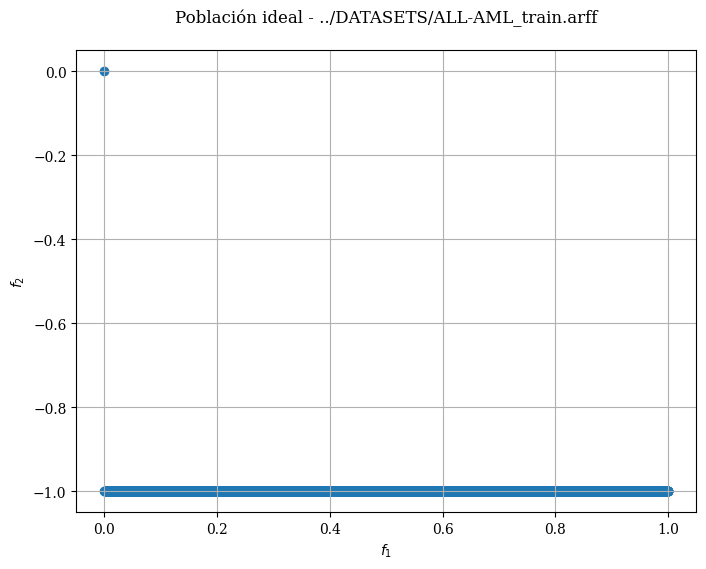

In [19]:
pf = problem.pareto_front()
print("Número de puntos de la población ideal ",DATASET_TRAIN_PATH," :",len(pf))    

title = "Población ideal - "+DATASET_TRAIN_PATH
VisualizacionPuntos(title,pf)

## Algoritmos evolutivos multiobjetivo

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $random\_state$: Semilla para reproducibilidad
- $prob$: Probabilidades
  - $prob\_cross$: Probabilidades de cruce
    - $p\_c$: Probabilidad de cruce
    - $uniform\_crossover\_probability$: Probabilidad de cruce uniforme
    - $arithmetic\_crossover\_probability$: Probabilidad de cruce aritmético
    - $SBX\_crossover\_probability$: Probabilidad de cruce SBX
  - $prob\_mutation$: Probabilidades de mutación
    - $p\_m$: Probabilidad de mutación
    - $uniform\_mutation\_probability$: Probabilidad de mutación uniforme 
    - $small\_mutation\_probability$: Probabilidad de mutación small 
    - $polynomial\_mutation\_probability$: Probabilidad de mutación small 
    - $epsilon$: Máximo cambio en mutación small
- $param$: Parámetros del ranking:
    - $amin$: Número esperado  de descendientes del peor individuo para selección por ranking lineal
    - $amax$:  Número esperado de descendientes del mejor individuo para selección por ranking lineal ($1<=amax<=2$)
    - $q$: Presión selectiva en ranking no lineal de Michalewicz, alto es más presión
    - $c$: Presión selectiva en ranking exponencial, bajo es más presión
    - $rank\_type$: Tipo de ranking: 'linear', 'nonlinear', 'exponential'

In [20]:
N = pop_size
G = n_gen

random_state = SEED

p_c = 0.6 # Probabilidad de cruce

p_m = 0.1  # Probabilidad de mutación

epsilon = 1e-6

amin = 0    # linear ranking
amax = 2-amin # linear ranking
q = 0.7 # non linear ranking
c = 0.3 # exponential ranking
rank_type = 'exponential'

param = amin,amax,q,c,rank_type

In [21]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n, dtype=bool)
        self.f2 = 0.0 # correlation-based score
        self.f1 = 1.0 # portion of selected features
    def __lt__(self, ind):
        # Orden lexicográfico
        if self.f1 < ind.f1:
            return True
        elif self.f1 > ind.f1:
            return False
        else:
            return self.f2 < ind.f2

In [22]:
def evaluate(I,f):           
    I.f1 = f1(I.x)
    I.f2 = f2(I.x)

In [23]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f1 = I2.f1
    I1.f2 = I2.f2   

In [24]:
amin = 0
amax = 2-amin
q = 0.7
c = 0.3
rank_type = 'exponential'

param = amin,amax,q,c,rank_type

def exp_probabilities(N,c):
    if N > 1:
        probs = c ** np.arange(N)
        probs *= (c-1) / (c ** N - 1)
        return probs
    else:
        return np.array([1.0])  

def calculate_cumulative_probabilities(cumulative_probabilities,P,N,param=param):
    amin,amax,q,c,rank_type = param    
    if rank_type == 'linear':
        cumulative_probabilities[0] = amax
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+(amax+(amin-amax)*i/(N-1))/N
    if rank_type == 'nonlinear':   
        cumulative_probabilities[0] = q
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+q*(1-q)**i    
    if rank_type == 'exponential':
        den = c**N-1
        cumulative_probabilities[0] = (c-1)/den
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+(c-1)*c**i/den
    return cumulative_probabilities

def cumulative_selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]

In [25]:
MAX_CROWDING_DISTANCE = 2.0
def calc_crowding_distance(F):
    """
    Calcula la distancia de crowding para un conjunto de soluciones en el espacio de objetivos.

    Args:
        F (numpy.ndarray): Matriz de objetivos de tamaño (n_puntos, n_objetivos).

    Returns:
        numpy.ndarray: Vector con las distancias de crowding para cada solución.
    """
    n_points, n_obj = F.shape
    if n_points <= 2:
        # Si hay 2 o menos puntos, asignar distancia infinita
        return np.full(n_points, MAX_CROWDING_DISTANCE)

    # Inicializar las distancias de crowding a cero
    distances = np.zeros(n_points)

    # Iterar sobre cada objetivo
    for i in range(n_obj):
        # Ordenar las soluciones según el objetivo i
        sorted_indices = np.argsort(F[:, i])
        sorted_F = F[sorted_indices, i]

        # Asignar distancia infinita a los extremos
        distances[sorted_indices[0]] = MAX_CROWDING_DISTANCE
        distances[sorted_indices[-1]] = MAX_CROWDING_DISTANCE

        # Calcular la distancia de crowding para los puntos intermedios
        for j in range(1, n_points - 1):
            if sorted_F[-1] - sorted_F[0] == 0:  # Evitar división por cero
                continue
            distances[sorted_indices[j]] += (
                (sorted_F[j + 1] - sorted_F[j - 1]) / (sorted_F[-1] - sorted_F[0])
            )

    return distances


class ExponentialDominanceSelection(Selection):
    def __init__(self, c=0.3):
        super().__init__()
        self.c = c
        self.param = amin,amax,q,c,'exponential'

    def _do(self, _, pop, n_select, n_parents, **kwargs):
        # Obtener el ranking de dominancia
        fronts = NonDominatedSorting().do(pop.get("F"), only_non_dominated_front=False)
        
        sorted_indices = []
        
        # Ordenar en cada frente por crowding distance
        for i, front in enumerate(fronts):
            # Calcular la distancia de crowding para cada frente
            crowding = calc_crowding_distance(pop.get("F")[front])
            # Ordenar nodos de forma decreciente por distancia de crowding
            sorted_front = np.argsort(-crowding)
            if np.random.random() < 0.5 and len(sorted_front) > 1:
                # Cambiar primer y segundo elemento (los extremos siempre tienen distancia máxima)
                sorted_front[0], sorted_front[1] = sorted_front[1], sorted_front[0]
            # Agregar índices ordenados al resultado
            for idx in sorted_front:
                sorted_indices.append(front[idx])
        
        # Seleccionar n_selected individuos basado en ranking exponencial
        probabilities = exp_probabilities(len(sorted_indices), self.c)
        selected_indices = np.random.choice(len(sorted_indices), size=n_select, p=probabilities, replace=True)

        # Convertir a matriz de padres
        selected = selected_indices
        return np.column_stack([selected] * n_parents)

# Construcción del algoritmo con selección personalizada
selector_exp = ExponentialDominanceSelection(c=0.3)
    

In [26]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling

class CustomBinarySampling(Sampling):
    def _do(self, problem, pop_size, **kwargs):
        # Crear una matriz de ceros para la población inicial
        samples = np.zeros((pop_size, problem.n_var), dtype=int)
        
        # Garantizar que la primera solución sea x = 0 (sin atributos seleccionados)
        samples[:2, :] = 0
        samples[-2:, :] = 1  # Solución con todos los atributos seleccionados
        
        # Generar el resto de las soluciones aleatoriamente
        for i in range(2, pop_size-2):
                sample = np.random.randint(0, 2, problem.n_var)
                samples[i, :] = sample

        return samples

def getAlgorithm(random_state, pop_size=pop_size, p_c=p_c, p_m=p_m, eliminate_duplicates=False):
        """
        Crea el algoritmo NSGA-II con los parámetros especificados.

        Args:
                random_state (int): Semilla para la aleatoriedad.
                pop_size (int): Tamaño de la población.
                p_c (float): Probabilidad de cruce.
                p_m (float): Probabilidad de mutación.
                eliminate_duplicates (bool): Si se deben eliminar duplicados.

        Returns:
                NSGA2: Instancia del algoritmo NSGA-II.
        """
        # Crear el algoritmo NSGA-II
        algorithm = NSGA2(
                        random_state=random_state,
                        pop_size=pop_size,
                        sampling=CustomBinarySampling(),  # Muestreo binario personalizado
                        crossover=UniformCrossover(prob=p_c),  # Uniform crossover with p_c = 0.6
                        mutation=BitflipMutation(prob=p_m),    # Bit-flip mutation with p_m = 0.1
                        selection=selector_exp,  # Exponential ranking selection with c = 0.3
                        eliminate_duplicates=eliminate_duplicates,
                        n_offsprings=pop_size)
        return algorithm

algorithm = getAlgorithm(random_state=SEED, pop_size=pop_size, p_c=p_c, p_m=p_m, eliminate_duplicates=False)

### Ejecución de los algoritmos

In [27]:
nadir = [1,0] # valores maximos [f1,f2]
maxArea = 1

hv_indicator = HV(ref_point=nadir, ideal_point=[0,-1], max_area=maxArea)

In [28]:
STEP = n_gen // 10 if not profiling else 2

class SparseCallback(Callback):
    def __init__(self, step=STEP):
        super().__init__()
        self.step = step
        self.history = []

    def notify(self, algorithm):
        self.history.append({
            "gen" : algorithm.n_gen,
            "hv" : hv_indicator(algorithm.pop.get("F")),
        })
        if self.step < 0:
            return
        if algorithm.n_gen % self.step == 0:
            _hist, _callback, _display = algorithm.history, algorithm.callback, algorithm.display

            algorithm.history, algorithm.callback, algorithm.display = None, None, None
            obj = copy.deepcopy(algorithm)

            algorithm.history, algorithm.callback, algorithm.display = _hist, _callback, _display
            algorithm.history.append(obj)
    
    def reset(self):
        self.history = []
            
alg_callback = SparseCallback(step=STEP)
termination = get_termination("n_gen", n_gen)

In [29]:
seed = SEED+0

if not DONE:
    print("Problema: ",DATASET_TRAIN_PATH)
    print("Algoritmo: NSGA2")
    start_time = time.time()
    res = minimize(problem=problem,
                    algorithm=algorithm,
                    termination=termination,
                    seed=seed,
                    save_history=False,
                    verbose=True,
                    callback=alg_callback)
    end_time = time.time()

    evolution_time = end_time - start_time
    print("Tiempo de ejecución: ", end_time - start_time)

Problema:  ../DATASETS/ALL-AML_train.arff
Algoritmo: NSGA2
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      igd      |       gd      |       hv     
     1 |       12 |      2 |  0.000000E+00 |  0.3333333333 |  0.5827667588 |  0.5123341531 |  0.2522919532


     2 |       24 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5827667588 |  0.5140622220 |  0.2522919532
     3 |       36 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5827667588 |  0.5137166082 |  0.2522919532
     4 |       48 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5827667588 |  0.5137166082 |  0.2522919532
     5 |       60 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5827667588 |  0.5133709945 |  0.2522919532
     6 |       72 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5827667588 |  0.5133709945 |  0.2522919532
     7 |       84 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5827665897 |  0.5120255615 |  0.2522950698
     8 |       96 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5827665897 |  0.5123711753 |  0.2522950698
     9 |      108 |     10 |  0.000000E+00 |  0.000000E+00 |  0.5827010874 |  0.5136111659 |  0.2523541541
    10 |      120 |      5 |  0.000000E+00 |  0.000000E+00 |  0.5825604388 |  0.5112940104 |  0.2527643308
    11 |      132 |     12 |  0.00000

In [30]:
# Guardar resultados

results_pikle = os.path.join(RESULTS_DIR, "results-0.pkl")
callbacks_pikle = os.path.join(RESULTS_DIR, "callbacks-0.pkl")

if not LOAD:
    print("Resultados guardados en: ",results_pikle)
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)

    with open(results_pikle, 'wb') as f:
        pickle.dump(res, f)
    
    
    with open(callbacks_pikle, 'wb') as f:
        pickle.dump(alg_callback, f)

else:
    print("Resultados cargados de: ",results_pikle)
    with open(results_pikle, 'rb') as f:
        res = pickle.load(f)
    
    with open(callbacks_pikle, 'rb') as f:
        alg_callback = pickle.load(f)

Resultados guardados en:  cbio_p15_results_profiling/results-0.pkl


### Imprimir los valores de la solución y fitness

In [31]:
print("Problema",problem.name(),",",problem.n_obj," objetivos:")
print("Algoritmo",algorithm.__class__.__name__)
print("Solución: \nX = %s\nF = %s" % (res.X, res.F))


Problema FeatureSelection , 2  objetivos:
Algoritmo NSGA2
Solución: 
X = [[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
F = [[ 0.4922149  -0.48985576]
 [ 0.48393884 -0.48578839]
 [ 0.49109272 -0.48855835]
 [ 0.49151354 -0.48929526]
 [ 0.49151354 -0.48929526]
 [ 0.48393884 -0.48578839]
 [ 0.48393884 -0.48578839]
 [ 0.48393884 -0.48578839]
 [ 0.48393884 -0.48578839]
 [ 0.4922149  -0.48985576]
 [ 0.49151354 -0.48929526]
 [ 0.48393884 -0.48578839]]


### Visualización de las soluciones obtenidas y del frente de Pareto

In [32]:
# Visualizar frente de Pareto
def VisualizacionFrentePareto(title, res):
    if (len(res.F[0])>3):
        scatter = PCP()
    else:
        scatter = Scatter(angle=(45, 45), title=title)
    scatter.add(res.F)
    scatter.show()
    plt.title(title,pad=20)
    plt.grid(True)
    plt.show()

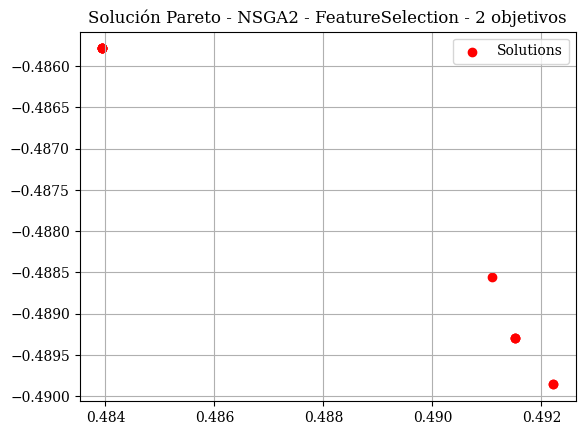

Individuo no dominado  0 :  [ 0.4922149  -0.48985576]
Individuo no dominado  1 :  [ 0.48393884 -0.48578839]
Individuo no dominado  2 :  [ 0.49109272 -0.48855835]
Individuo no dominado  3 :  [ 0.49151354 -0.48929526]
Individuo no dominado  4 :  [ 0.49151354 -0.48929526]
Individuo no dominado  5 :  [ 0.48393884 -0.48578839]
Individuo no dominado  6 :  [ 0.48393884 -0.48578839]
Individuo no dominado  7 :  [ 0.48393884 -0.48578839]
Individuo no dominado  8 :  [ 0.48393884 -0.48578839]
Individuo no dominado  9 :  [ 0.4922149  -0.48985576]
Individuo no dominado  10 :  [ 0.49151354 -0.48929526]
Individuo no dominado  11 :  [ 0.48393884 -0.48578839]
Individuos no dominados:  12


In [33]:
def VisualizacionSolucion(title,f):
    if (len(f[0])>2):
        VisualizacionPuntos(title,f)
        return
    
    fig, ax = plt.subplots()
    
    # Agregar las soluciones obtenidas
    x = [v[0] for v in f]
    y = [v[1] for v in f]
    ax.scatter(x, y, color='red', label='Solutions')

    # Mostrar el título
    plt.title(title)

    # Mostrar la leyenda
    plt.legend()    

    plt.grid(True)
    
    plt.show()
    
title = "Solución Pareto - "+algorithm.__class__.__name__ +" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos"
VisualizacionSolucion(title,res.F)
nds = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
for i in range(len(nds)):
    print("Individuo no dominado ",i,": ",res.F[nds[i]])
print("Individuos no dominados: ",len(nds))

### Indicadores de rendimiento

In [34]:
print("Base de datos:",DATASET_TRAIN_PATH)    
nadir = [1,0]
maxArea = 1
indicator = [
        GD(pf),
        GDPlus(pf),
        IGD(pf),
        IGDPlus(pf),
        HV(nadir)
]
cadena = " \t \t "
print("NSGA2 \t \t \t ")
for iIndicator in range(len(indicator)):
    cadena = indicator[iIndicator].__class__.__name__+" \t "
    if (len(cadena)<10):
        cadena += " \t "
    cadena += str(indicator[iIndicator](res.F))+" \t "
    print(cadena)
cadena = "HV normalized \t "
cadena += str(indicator[len(indicator)-1](res.F)/maxArea)+" \t "
print(cadena)

Base de datos: ../DATASETS/ALL-AML_train.arff
NSGA2 	 	 	 
GD 	  	 0.5124261643913447 	 
GDPlus 	  	 0.4878080142142423 	 
IGD 	  	 0.582560438845865 	 
IGDPlus 	 0.5445564470514056 	 
HV 	  	 0.2527654964271019 	 
HV normalized 	 0.2527654964271019 	 


### Visualización de la evolución de los algoritmos

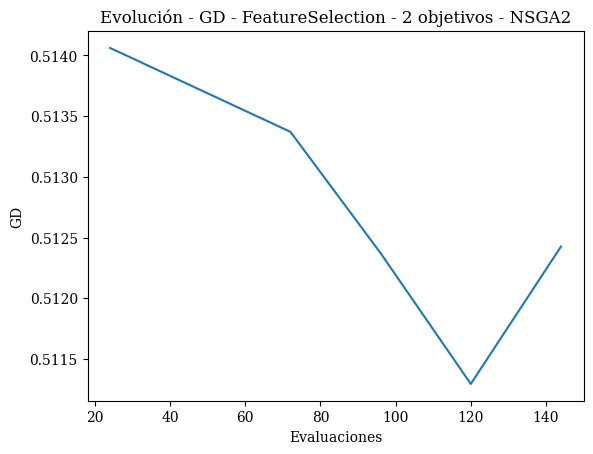

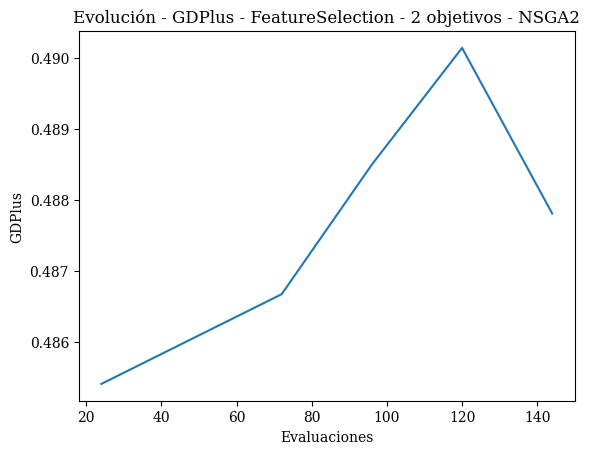

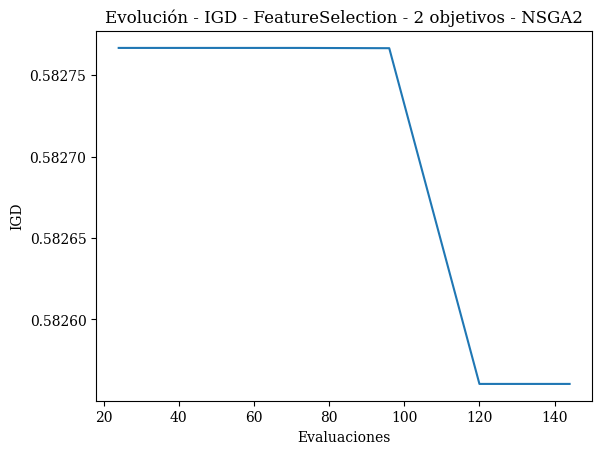

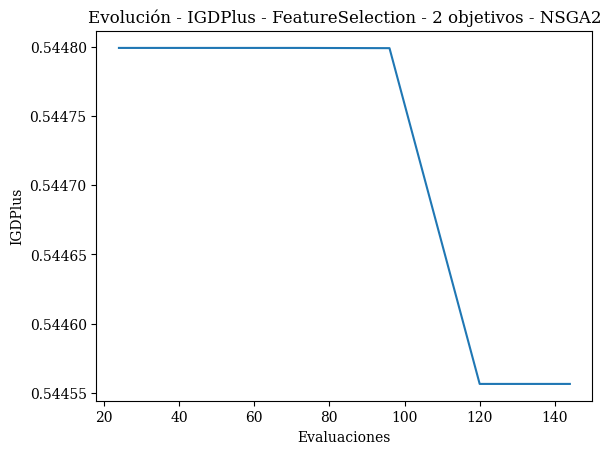

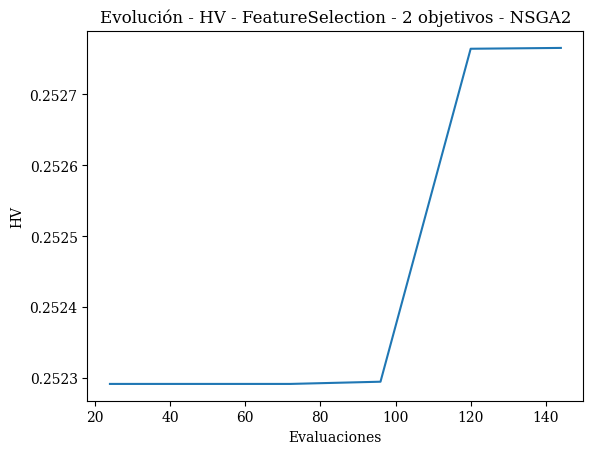

In [35]:
def VisualizacionEvolucion(title,res,values,yTitle):    
    n_evals = np.array([e.evaluator.n_eval for e in res.history]) # array con los números de evaluaciones
    fig, ax = plt.subplots()
    ax.set_title(title)
    plt.plot(n_evals, values)
    plt.xlabel("Evaluaciones")
    plt.ylabel(yTitle)
    plt.show() 

for iIndicator in range(len(indicator)):
    values = np.array([indicator[iIndicator](e.opt.get("F")) for e in res.history])
    title = "Evolución - "+indicator[iIndicator].__class__.__name__+" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos - "+algorithm.__class__.__name__ 
    VisualizacionEvolucion(title,res,values,indicator[iIndicator].__class__.__name__)

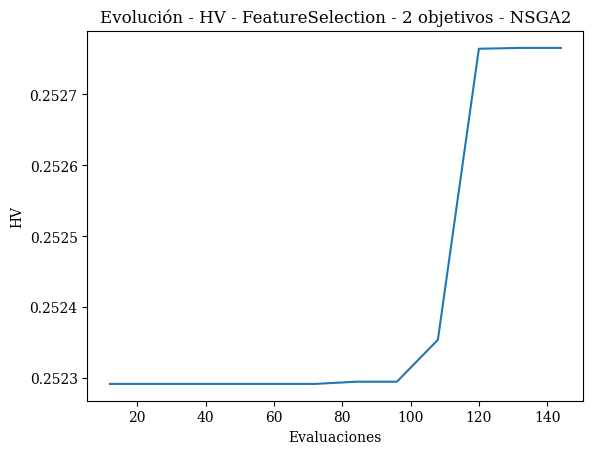

In [36]:
def VisualizacionEvolucionHV(title,n_evals,values,yTitle):    
    fig, ax = plt.subplots()
    ax.set_title(title)
    plt.plot(n_evals, values)
    plt.xlabel("Evaluaciones")
    plt.ylabel(yTitle)
    plt.show() 


name = hv_indicator.__class__.__name__
ns_gen = np.array([e['gen'] for e in alg_callback.history])
n_evals = pop_size*ns_gen
values = np.array([e['hv'] for e in alg_callback.history])
title = "Evolución - "+hv_indicator.__class__.__name__+" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos - "+algorithm.__class__.__name__ 
VisualizacionEvolucionHV(title,n_evals,values,hv_indicator.__class__.__name__)

## Test con los modelos de clasificación

In [37]:
def getEstimators(random_state=None):
    estimators = [RandomForestClassifier(random_state=random_state), 
                SVC(random_state=random_state), 
                MLPClassifier(random_state=random_state)]
    return estimators

seed = SEED+0
estimators = getEstimators(random_state=seed)

# Guardar dataframe con columnas: seed, RF_train_acc, RF_test_acc, SVC_train_acc, SVC_test_acc, MLP_train_acc, MLP_test_acc

estimator_names = ['RF', 'SVC', 'MLP']
estimator_indexes = {name: i for i, name in enumerate(estimator_names)}

columns = ['seed', 'HV', 'time']
for name in estimator_names:
    columns.append(name+'_train_acc')
for name in estimator_names:
    columns.append(name+'_test_acc')
for name in estimator_names:
    columns.append(name+'_val_acc')

scores_dict0 = {col: [] for col in columns}

def add_results_to_dict(scores_dict, seed, hv, time, train_scores, test_scores, val_scores):
    # Agregar resultados al diccionario
    scores_dict['seed'].append(seed)
    scores_dict['HV'].append(hv)
    scores_dict['time'].append(time)
    
    for i, name in enumerate(estimator_names):
        scores_dict[name+'_train_acc'].append(train_scores[i])
        scores_dict[name+'_test_acc'].append(test_scores[i])
        scores_dict[name+'_val_acc'].append(val_scores[i])
    return scores_dict

def add_results_to_df(df, seed, hv, time, train_scores, test_scores, val_scores):
    # Crear un nuevo DataFrame con los resultados
    new_row = {
        'seed': seed,
        'HV': hv,
        'time': time
    }
    
    for i, name in enumerate(estimator_names):
        new_row[name+'_train_acc'] = train_scores[i]
        new_row[name+'_test_acc'] = test_scores[i]
        new_row[name+'_val_acc'] = val_scores[i]
        
    # Concatenar el nuevo DataFrame al existente
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    
    return df

In [38]:
hv = hv_indicator(res.F)

new_row = {
    'seed': seed,
    'HV': hv
}

train_scores = []
test_scores = []
val_scores = []

nds = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
nd_solutions = res.X[nds]
print("Número de soluciones no dominadas: ",len(nd_solutions))

Número de soluciones no dominadas:  12


In [39]:
if not DONE:
    for estimator in estimators:
        j_max = 0
        val_max = -1
        
        print("Entrenando clasificador: ", estimator.__class__.__name__)
        for i, solution in enumerate(nd_solutions):
            n_selected = np.sum(solution)
            #print(f"Evaluando solución {i+1}/{len(nd_solutions)} con {n_selected} features")
            selected_features = np.where(solution == 1)[0]
            X = X_train.iloc[:, selected_features]

            val_accuracy = cross_val_score(estimator, X, y_train, cv=cv)
            mean_val_accuracy = np.mean(val_accuracy)
            if mean_val_accuracy > val_max:
                j_max = i
                val_max = mean_val_accuracy
                
        print("Mejor solución: ", j_max, " con ", val_max, "acc de validación y ", np.sum(nd_solutions[j_max]), " features")
        
        selected_features = np.where(nd_solutions[j_max] == 1)[0]
        X = X_train.iloc[:, selected_features]
        estimator.fit(X, y_train)
        
        train_accuracy = estimator.score(X, y_train)
        test_accuracy = estimator.score(X_test.iloc[:,selected_features], y_test)
        val_accuracy = val_max
        
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)
        val_scores.append(val_accuracy)
        
        print(f"Validation accuracy: {val_accuracy}")
        print(f"Train accuracy: {train_accuracy}")
        print(f"Test accuracy: {test_accuracy}")
        
        print("----------------------")


    # Guardar resultados en el diccionario
    add_results_to_dict(scores_dict0, seed, hv, evolution_time, train_scores, test_scores, val_scores)

Entrenando clasificador:  RandomForestClassifier
Mejor solución:  1  con  0.868421052631579 acc de validación y  3450  features
Validation accuracy: 0.868421052631579
Train accuracy: 1.0
Test accuracy: 0.7941176470588235
----------------------
Entrenando clasificador:  SVC
Mejor solución:  0  con  0.7105263157894737 acc de validación y  3509  features
Validation accuracy: 0.7105263157894737
Train accuracy: 0.8157894736842105
Test accuracy: 0.5882352941176471
----------------------
Entrenando clasificador:  MLPClassifier
Mejor solución:  0  con  0.9736842105263157 acc de validación y  3509  features
Validation accuracy: 0.9736842105263157
Train accuracy: 0.9210526315789473
Test accuracy: 0.8235294117647058
----------------------


In [40]:
# Guardar resultados

path_csv_scores = os.path.join(RESULTS_DIR, "scores-0.csv")

if not LOAD:
    df = pd.DataFrame(scores_dict0)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores)

else:
    # Cargar resultados
    df = pd.read_csv(path_csv_scores)
    
    scores_dict = df.to_dict(orient='list')
    scores_df = pd.DataFrame(scores_dict)

In [41]:
display(scores_dict0)

{'seed': [2025],
 'HV': [0.2527654964271019],
 'time': [2.2617337703704834],
 'RF_train_acc': [1.0],
 'SVC_train_acc': [0.8157894736842105],
 'MLP_train_acc': [0.9210526315789473],
 'RF_test_acc': [0.7941176470588235],
 'SVC_test_acc': [0.5882352941176471],
 'MLP_test_acc': [0.8235294117647058],
 'RF_val_acc': [0.868421052631579],
 'SVC_val_acc': [0.7105263157894737],
 'MLP_val_acc': [0.9736842105263157]}

### Evaluar modelos con todas las features

In [42]:
if not DONE:
    estimators = getEstimators(random_state=SEED)
    for estimator in estimators:
        print(f"Entrenando clasificador: {estimator.__class__.__name__}")
        estimator.fit(X_train[:], y_train)
        
        train_accuracy = estimator.score(X_train[:], y_train)
        test_accuracy = estimator.score(X_test[:], y_test)
        
        
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)
        
        # K-fold CV Validation accuracy
        
        val_accuracy = cross_val_score(estimator, X_train[:], y_train, cv=cv)
        mean_val_accuracy = np.mean(val_accuracy)
        val_scores.append(mean_val_accuracy)
        
        print(f"Validation accuracy: {mean_val_accuracy}")
        print(f"Train accuracy: {train_accuracy}")
        print(f"Test accuracy: {test_accuracy}")

    scores_all_dict = {col: [] for col in columns}
    seed = SEED
    hv = 0
    # Agregar resultados al diccionario
    scores_all_dict = add_results_to_dict(scores_all_dict, seed, hv, 0, train_scores, test_scores, val_scores)

Entrenando clasificador: RandomForestClassifier
Validation accuracy: 0.8421052631578947
Train accuracy: 1.0
Test accuracy: 0.7352941176470589
Entrenando clasificador: SVC
Validation accuracy: 0.7105263157894737
Train accuracy: 0.8157894736842105
Test accuracy: 0.6176470588235294
Entrenando clasificador: MLPClassifier
Validation accuracy: 0.868421052631579
Train accuracy: 0.9210526315789473
Test accuracy: 0.8529411764705882


In [43]:
# Guardar resultados

path_csv_scores_all = os.path.join(RESULTS_DIR, "scores-all.csv")
results_pikle_all = os.path.join(RESULTS_DIR, "results-all.pkl")
callbacks_pikle_all = os.path.join(RESULTS_DIR, "callbacks-all.pkl")

if not LOAD:
    df = pd.DataFrame(scores_all_dict)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores_all)

    with open(results_pikle_all, 'wb') as f:
        pickle.dump(res, f)
    
    
    with open(callbacks_pikle_all, 'wb') as f:
        pickle.dump(alg_callback, f)

else:
    # Cargar resultados
    df = pd.read_csv(path_csv_scores_all)
    with open(results_pikle_all, 'rb') as f:
        res = pickle.load(f)
    
    with open(callbacks_pikle_all, 'rb') as f:
        alg_callback = pickle.load(f)
    
    scores_all_dict = df.to_dict(orient='list')
    scores_all_df = pd.DataFrame(scores_all_dict)

In [44]:
display(scores_all_dict)

{'seed': [2025],
 'HV': [0],
 'time': [0],
 'RF_train_acc': [1.0],
 'SVC_train_acc': [0.8157894736842105],
 'MLP_train_acc': [0.9210526315789473],
 'RF_test_acc': [0.7941176470588235],
 'SVC_test_acc': [0.5882352941176471],
 'MLP_test_acc': [0.8235294117647058],
 'RF_val_acc': [0.868421052631579],
 'SVC_val_acc': [0.7105263157894737],
 'MLP_val_acc': [0.9736842105263157]}

In [45]:
# Exclude 'HV' and 'time' columns from the DataFrame
df_all = pd.DataFrame({key: value for key, value in scores_all_dict.items() if key not in ['HV', 'time']})
display(df_all)

,seed,RF_train_acc,SVC_train_acc,MLP_train_acc,RF_test_acc,SVC_test_acc,MLP_test_acc,RF_val_acc,SVC_val_acc,MLP_val_acc
0,2025,1.0,0.815789,0.921053,0.794118,0.588235,0.823529,0.868421,0.710526,0.973684


### Varias SEED

In [46]:
print("Problema: ",DATASET_TRAIN_PATH)
print("Algoritmo: NSGA2")

scores_dict = {col: [] for col in columns}
seeds = np.arange(SEED+1, SEED+11)
times = np.zeros((len(seeds),))
results = []
hvs = np.zeros((len(seeds),))

alg_callbacks = []
if not DONE:
    for t in range(1,11):
        print(f"Ejecutando prueba {t} de 10")
        
        seed = SEED+t
        np.random.seed(seed)
        random_state = seed
        
        alg_callback = SparseCallback(step=-1)
        algorithm = getAlgorithm(random_state=random_state)
        start_time = time.time()
        
        res = minimize(problem=problem,
                        algorithm=algorithm,
                        termination=termination,
                        seed=random_state,
                        save_history=False,
                        verbose=True,
                        callback=alg_callback)
        
        end_time = time.time()
        
        evolution_time = end_time - start_time
        print(f"Tiempo de evolución: {evolution_time:.2f} segundos")
        
        hv = hv_indicator(res.F)
        
        results.append(res)
        alg_callbacks.append(alg_callback)
        times[t-1] = evolution_time
        hvs[t-1] = hv
       

Problema:  ../DATASETS/ALL-AML_train.arff
Algoritmo: NSGA2
Ejecutando prueba 1 de 10
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      igd      |       gd      |       hv     
     1 |       12 |      2 |  0.000000E+00 |  0.3333333333 |  0.5793135985 |  0.5094685795 |  0.2504374678
     2 |       24 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5792336109 |  0.5100312940 |  0.2504403000
     3 |       36 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5792336109 |  0.5077841272 |  0.2504403000
     4 |       48 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5792336109 |  0.5089077106 |  0.2504403000
     5 |       60 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5792336109 |  0.5072668803 |  0.2504420414
     6 |       72 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5792336109 |  0.5072668803 |  0.2504420414
     7 |       84 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5792335867 |  0.5067019341 |  0.2505787646
     8 |       96 |      7 |  0.000000E+00 |  0.000000E+00 

In [47]:
if not DONE:
    for t in range(1,11):
        print(f"Ejecutando prueba {t} de 10")
        
        seed = SEED+t
        np.random.seed(seed)
        random_state = seed
        
        res = results[t-1]
        hv = hvs[t-1]
        evolution_time = times[t-1]
        
        nds = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
        nd_solutions = res.X[nds]
        
        estimators = getEstimators(random_state=seed)
        train_scores = []
        test_scores = []
        val_scores = []
        for estimator in estimators:
            j_max = 0
            val_max = -1
            print("Entrenando clasificador: ", estimator.__class__.__name__)
            for i, solution in enumerate(nd_solutions):
                n_selected = np.sum(solution)
                #print(f"Evaluando solución {i+1}/{len(nd_solutions)} con {n_selected} features")
                selected_features = np.where(solution == 1)[0]
                X = X_train.iloc[:, selected_features]

                val_accuracy = cross_val_score(estimator, X, y_train, cv=cv)
                mean_val_accuracy = np.mean(val_accuracy)
                if mean_val_accuracy > val_max:
                    j_max = i
                    val_max = mean_val_accuracy
                    
            print("Mejor solución: ", j_max, " con ", val_max, "acc de validación y ", np.sum(nd_solutions[j_max]), " features")
            
            selected_features = np.where(nd_solutions[j_max] == 1)[0]
            X = X_train.iloc[:, selected_features]
            estimator.fit(X, y_train)
            
            train_accuracy = estimator.score(X, y_train)
            test_accuracy = estimator.score(X_test.iloc[:,selected_features], y_test)
            val_accuracy = val_max
            
            train_scores.append(train_accuracy)
            test_scores.append(test_accuracy)
            val_scores.append(val_accuracy)
            
            print(f"Validation accuracy: {val_accuracy}")
            print(f"Train accuracy: {train_accuracy}")
            print(f"Test accuracy: {test_accuracy}")
            print("---------")
            print()
        add_results_to_dict(scores_dict, seed, hv, evolution_time, train_scores, test_scores, val_scores)
        

        print("--------------------")

Ejecutando prueba 1 de 10
Entrenando clasificador:  RandomForestClassifier
Mejor solución:  1  con  0.8421052631578947 acc de validación y  3526  features
Validation accuracy: 0.8421052631578947
Train accuracy: 1.0
Test accuracy: 0.7352941176470589
---------

Entrenando clasificador:  SVC
Mejor solución:  1  con  0.7368421052631579 acc de validación y  3526  features
Validation accuracy: 0.7368421052631579
Train accuracy: 0.8157894736842105
Test accuracy: 0.6764705882352942
---------

Entrenando clasificador:  MLPClassifier
Mejor solución:  3  con  0.9210526315789473 acc de validación y  3515  features
Validation accuracy: 0.9210526315789473
Train accuracy: 0.9736842105263158
Test accuracy: 0.8235294117647058
---------

--------------------
Ejecutando prueba 2 de 10
Entrenando clasificador:  RandomForestClassifier
Mejor solución:  3  con  0.868421052631579 acc de validación y  3503  features
Validation accuracy: 0.868421052631579
Train accuracy: 1.0
Test accuracy: 0.8235294117647058
--

In [48]:
# Guardar resultados

path_csv_scores = os.path.join(RESULTS_DIR, "scores-10.csv")
results_pikle = os.path.join(RESULTS_DIR, "results-10.pkl")
callbacks_pikle = os.path.join(RESULTS_DIR, "callbacks-10.pkl")

if not LOAD:
    df = pd.DataFrame(scores_dict)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores)

    with open(results_pikle, 'wb') as f:
        pickle.dump(results, f)
    
    
    with open(callbacks_pikle, 'wb') as f:
        pickle.dump(alg_callbacks, f)

else:
    # Cargar resultados
    df = pd.read_csv(path_csv_scores)
    with open(results_pikle, 'rb') as f:
        results = pickle.load(f)
    
    with open(callbacks_pikle, 'rb') as f:
        alg_callbacks = pickle.load(f)
    
    scores_dict = df.to_dict(orient='list')
    scores_df = pd.DataFrame(scores_dict)

In [49]:
display(scores_dict)

{'seed': [2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035],
 'HV': [0.2509069442575348,
  0.2489434211041176,
  0.2440411747001913,
  0.2500254824705714,
  0.24731763974139118,
  0.24875964795526664,
  0.2517045013760372,
  0.24886643834332622,
  0.24669009079809018,
  0.2467368277428265],
 'time': [1.9319820404052734,
  1.8655335903167725,
  1.851358413696289,
  1.8073046207427979,
  1.7843518257141113,
  1.9829843044281006,
  1.9269120693206787,
  1.8223357200622559,
  2.033548355102539,
  1.809145212173462],
 'RF_train_acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'SVC_train_acc': [0.8157894736842105,
  0.8157894736842105,
  0.8157894736842105,
  0.8157894736842105,
  0.8157894736842105,
  0.8157894736842105,
  0.7894736842105263,
  0.8157894736842105,
  0.8157894736842105,
  0.8157894736842105],
 'MLP_train_acc': [0.9736842105263158,
  0.9736842105263158,
  1.0,
  1.0,
  0.9736842105263158,
  1.0,
  0.9736842105263158,
  1.0,
  1.0,
  1.0],
 'RF_test_acc': [

In [50]:
scores_df = pd.DataFrame(scores_dict)
scores_df

,seed,HV,time,RF_train_acc,SVC_train_acc,MLP_train_acc,RF_test_acc,SVC_test_acc,MLP_test_acc,RF_val_acc,SVC_val_acc,MLP_val_acc
0,2026,0.250907,1.931982,1.0,0.815789,0.973684,0.735294,0.676471,0.823529,0.842105,0.736842,0.921053
1,2027,0.248943,1.865534,1.0,0.815789,0.973684,0.823529,0.588235,0.882353,0.868421,0.710526,0.894737
2,2028,0.244041,1.851358,1.0,0.815789,1.000000,0.764706,0.705882,0.852941,0.868421,0.710526,0.947368
3,2029,0.250025,1.807305,1.0,0.815789,1.000000,0.823529,0.764706,0.911765,0.842105,0.710526,0.894737
4,2030,0.247318,1.784352,1.0,0.815789,0.973684,0.764706,0.647059,0.852941,0.868421,0.710526,0.894737
5,2031,0.248760,1.982984,1.0,0.815789,1.000000,0.823529,0.588235,0.941176,0.842105,0.710526,0.921053
6,2032,0.251705,1.926912,1.0,0.789474,0.973684,0.764706,0.588235,0.823529,0.842105,0.710526,0.973684
7,2033,0.248866,1.822336,1.0,0.815789,1.000000,0.735294,0.588235,0.852941,0.868421,0.710526,0.894737
8,2034,0.246690,2.033548,1.0,0.815789,1.000000,0.794118,0.588235,0.852941,0.894737,0.710526,0.973684
9,2035,0.246737,1.809145,1.0,0.815789,1.000000,0.764706,0.588235,0.970588,0.868421,0.710526,0.973684


In [51]:
# Reportar tabla con columnas: seed, hv, time, rf_train_acc, rf_test_acc, svc_train_acc, svc_test_acc, mlp_train_acc, mlp_test_acc
# añadir filas adicionales: mejor, peor, media y desviación típica

# Crear un nuevo DataFrame con los resultados
summary_dict = {}
summary_dict['seed'] = ['best', 'worst', 'mean', 'std']

hvs = scores_df['HV'].to_numpy()
summary_dict['HV'] = [np.max(hvs), np.min(hvs), np.mean(hvs), np.std(hvs)]

times = scores_df['time'].to_numpy()
summary_dict['time'] = [np.min(times), np.max(times), np.mean(times), np.std(times)]

for metric in ['train_acc', 'test_acc']:
    for i, name in enumerate(estimator_names):
        metric_name = f"{name}_{metric}"
        metric_values = scores_df[metric_name].to_numpy()
        summary_dict[metric_name] = [np.max(metric_values), np.min(metric_values), np.mean(metric_values), np.std(metric_values)]

summary_df = pd.DataFrame(summary_dict)
summary_df = summary_df.set_index('seed')
# renombrar columna seed a stat
summary_df = summary_df.rename_axis('stat')

display(summary_df)


,HV,time,RF_train_acc,SVC_train_acc,MLP_train_acc,RF_test_acc,SVC_test_acc,MLP_test_acc
stat,,,,,,,,
best,0.251705,1.784352,1.0,0.815789,1.000000,0.823529,0.764706,0.970588
worst,0.244041,2.033548,1.0,0.789474,0.973684,0.735294,0.588235,0.823529
mean,0.248399,1.881546,1.0,0.813158,0.989474,0.779412,0.632353,0.876471
std,0.002153,0.079291,0.0,0.007895,0.012892,0.032883,0.060634,0.047059


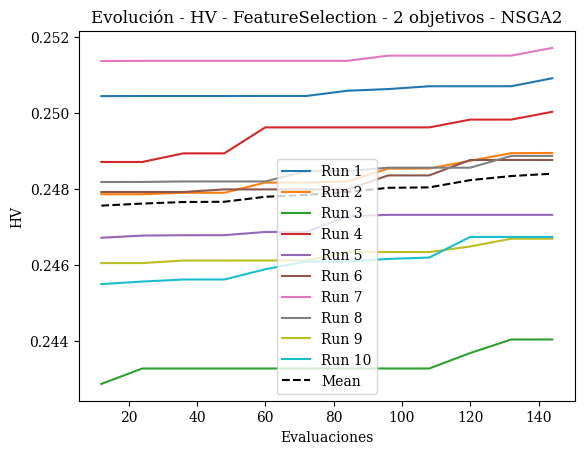

In [52]:
fig, ax = plt.subplots()
title = "Evolución - "+hv_indicator.__class__.__name__+" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos - "+algorithm.__class__.__name__ 

ax.set_title(title)
plt.xlabel("Evaluaciones")
yTitle = hv_indicator.__class__.__name__
plt.ylabel(yTitle)

n_evals_mean = np.zeros((len(alg_callback.history),))
values_mean = np.zeros((len(alg_callback.history),))

for i, alg_callback in enumerate(alg_callbacks):
    ns_gen = np.array([e['gen'] for e in alg_callback.history])
    n_evals = pop_size*ns_gen
    values = np.array([e['hv'] for e in alg_callback.history])
    plt.plot(n_evals, values, label=f"Run {i+1}")
    
    n_evals_mean += n_evals
    values_mean += values
n_evals_mean = n_evals_mean/len(alg_callbacks)
values_mean = values_mean/len(alg_callbacks)
plt.plot(n_evals_mean, values_mean, label="Mean", color='black', linestyle='--')

plt.legend()
plt.show() 

In [53]:
scores_df.describe()

,seed,HV,time,RF_train_acc,SVC_train_acc,MLP_train_acc,RF_test_acc,SVC_test_acc,MLP_test_acc,RF_val_acc,SVC_val_acc,MLP_val_acc
count,10.00000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2030.50000,0.248399,1.881546,1.0,0.813158,0.989474,0.779412,0.632353,0.876471,0.860526,0.713158,0.928947
std,3.02765,0.002269,0.083580,0.0,0.008322,0.013589,0.034662,0.063914,0.049604,0.017762,0.008322,0.035197
min,2026.00000,0.244041,1.784352,1.0,0.789474,0.973684,0.735294,0.588235,0.823529,0.842105,0.710526,0.894737
25%,2028.25000,0.246882,1.812443,1.0,0.815789,0.973684,0.764706,0.588235,0.852941,0.842105,0.710526,0.894737
50%,2030.50000,0.248813,1.858446,1.0,0.815789,1.000000,0.764706,0.588235,0.852941,0.868421,0.710526,0.921053
75%,2032.75000,0.249755,1.930715,1.0,0.815789,1.000000,0.816176,0.669118,0.904412,0.868421,0.710526,0.967105
max,2035.00000,0.251705,2.033548,1.0,0.815789,1.000000,0.823529,0.764706,0.970588,0.894737,0.736842,0.973684


## 7. Conclusiones


## Referencias

- Jiménez Barrionuevo, F., & Sánchez Carpena, G. (2025). Computación Bio-inspirada. Tema 5: Algoritmos bio-inspirados para machine learning. Máster en Inteligencia Artificial, Universidad de Murcia. Departamento de Ingeniería de la Información y las Comunicaciones. Disponible en: https://aulavirtual.um.es/access/content/group/7933_P_2024_N_N/2.%20Diapositivas%20de%20clase/Tema5.pdf
- pymoo documentation. pymoo: Multi-objective Optimization in Python. Disponible en: https://pymoo.org (Accedido el 21 de abril de 2025).
- Hall, M. A. (1999). Correlation-based feature selection for discrete and numeric class machine learning. In Proceedings of the 17th International Conference on Machine Learning (ICML-2000) (pp. 359-366). Morgan Kaufmann. Disponible en https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=0e78b20b27d27261f9ae088eb13201f2d5b185bd (Accedido el 21 de abril de 2025).

## Contribución de cada miembro del grupo

- Santiago Méndez García:
 
- Domingo Méndez García: 
  - Presentación oral.